# Fine tuning _u-net_ using RENABAP mask and Sentinel-2

In [1]:
import geopandas as gpd
from urllib import request
from zipfile import ZipFile
import rasterio
import os
import fiona

In [2]:
import pandas as pd
import numpy as np
import IPython.display as disp

In [3]:
df = gpd.read_file('../../data/amba.geojson')

In [4]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator


For the training, the paths for training

In [15]:
path_to_files = './inputs/7_2021.tif'
vector_file = "./inputs/mask.geojson"
output_folder = './inputs/'

For generating the mask, TCI (_True Color Image_) was extracted

In [20]:
TCI_path = './inputs/7_2021_TCI.tif'

<AxesSubplot:>

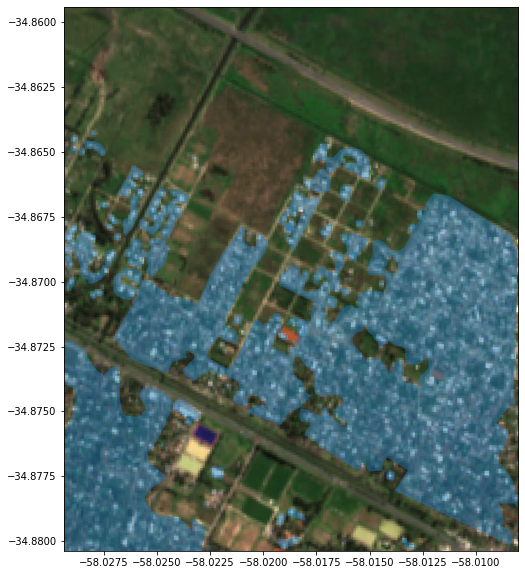

In [21]:
import rasterio
from matplotlib import pyplot
from matplotlib import pyplot as plt
from rasterio.plot import show


fig, ax = plt.subplots(figsize=(10,10))

src = rasterio.open(TCI_path)
gdf = gpd.read_file(vector_file)
show(src.read(), transform=src.transform,ax = ax)
gdf.plot(ax=ax, alpha = 0.5)

But the masking image is a RGB image. For training, not only the RGB bands were extracted, but also:

+ SWIR 1  (Short Wave Infrared Band 1)

+ NIR (Near Infrared)

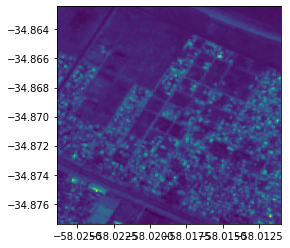

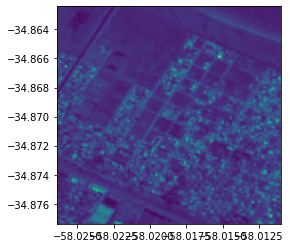

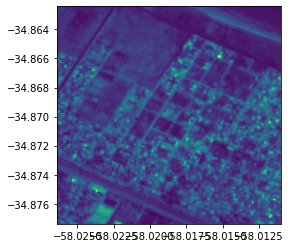

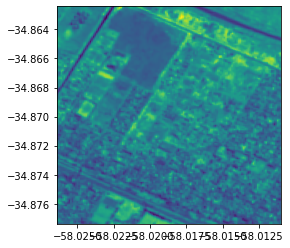

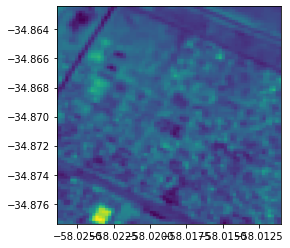

In [27]:
src = rasterio.open(path_to_files)
for i in range(5):
    show(src.read(i+1), transform=src.transform)

In [28]:
import glob
import os
from tqdm import tqdm
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

After several tries, the size of the image selected for the windows are 300x300 images (chips), with a step size of 90 pixels

In [13]:
size =300
step_size = 90

The package _satproc_extract_chips_ was used for extract each chip, toghether with the masks 

In [ ]:
!satproc_extract_chips \
    $path_to_files \
    -o  $output_folder \
    --size $size \
    --step-size $step_size \
    --aoi $vector_file \
    --labels $vector_file \
    --label-property id \
    --classes 1

Rasters:   0% 0/1 [00:00<?, ?it/s]
7_2021.tif windows:   0% 0/216 [00:00<?, ?it/s]
7_2021.tif windows:   0% 1/216 [00:00<02:46,  1.29it/s]
7_2021.tif windows:   2% 4/216 [00:00<00:37,  5.72it/s]
7_2021.tif windows:   4% 8/216 [00:01<00:18, 11.21it/s]
7_2021.tif windows:   6% 12/216 [00:01<00:12, 16.38it/s]
7_2021.tif windows:   7% 15/216 [00:01<00:10, 19.20it/s]
7_2021.tif windows:   9% 19/216 [00:01<00:08, 22.95it/s]
7_2021.tif windows:  10% 22/216 [00:01<00:08, 23.78it/s]
7_2021.tif windows:  12% 26/216 [00:01<00:07, 26.29it/s]
7_2021.tif windows:  14% 30/216 [00:01<00:06, 27.67it/s]
7_2021.tif windows:  16% 34/216 [00:01<00:06, 28.09it/s]
7_2021.tif windows:  18% 38/216 [00:01<00:05, 30.12it/s]
7_2021.tif windows:  19% 42/216 [00:02<00:05, 29.82it/s]
7_2021.tif windows:  21% 46/216 [00:02<00:05, 30.76it/s]
7_2021.tif windows:  23% 50/216 [00:02<00:05, 29.22it/s]
7_2021.tif windows:  25% 54/216 [00:02<00:05, 30.42it/s]
7_2021.tif windows:  27% 58/216 [00:02<00:05, 29.69it/s]
7_2021.t

In [ ]:
lens = len(os.listdir(os.path.join(output_folder,"images"))) #For a parameter

In [ ]:
config = TrainConfig(width=160,  #Size of the image processed by the UNet (must be multiples of 16, for example 160, 320, etc.).
                     height=160,
                     n_channels=5,  #  number of channels -> 5
                     n_classes=1, # A mask with only one class masked (builded)
                     apply_image_augmentation=True,
                     seed=42,
                     epochs=11,
                     batch_size=64,
                     steps_per_epoch=int(lens*.7),
                     early_stopping_patience=5,
                     validation_split=0.2,
                     test_split=0.1,
                     images_path=output_folder,
                     model_path=os.path.join('./modelo/weights/', 'UNet_renabap_4.h5'),
                     model_architecture='unet',
                     evaluate=False  ,
                     class_weights= [1]) 

The package includes a function to map each training images with it's corresponding mask

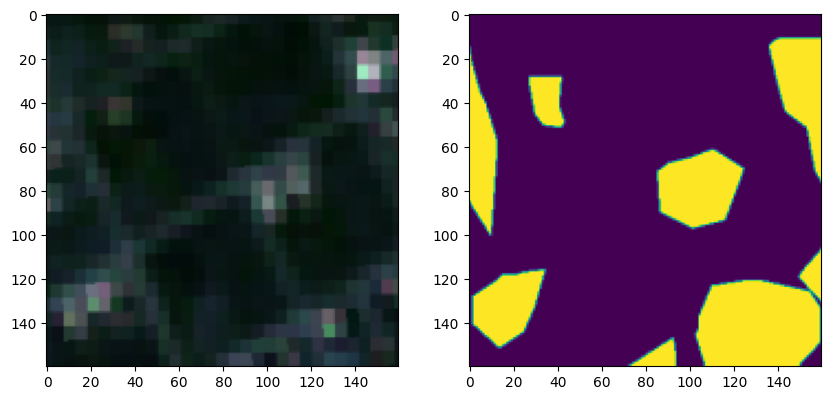

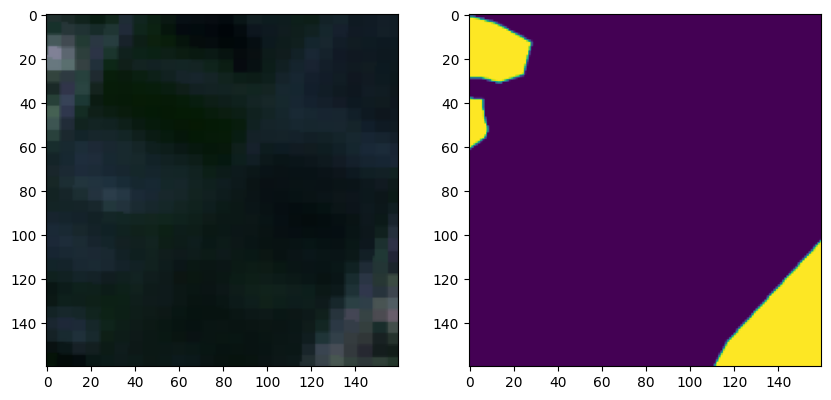

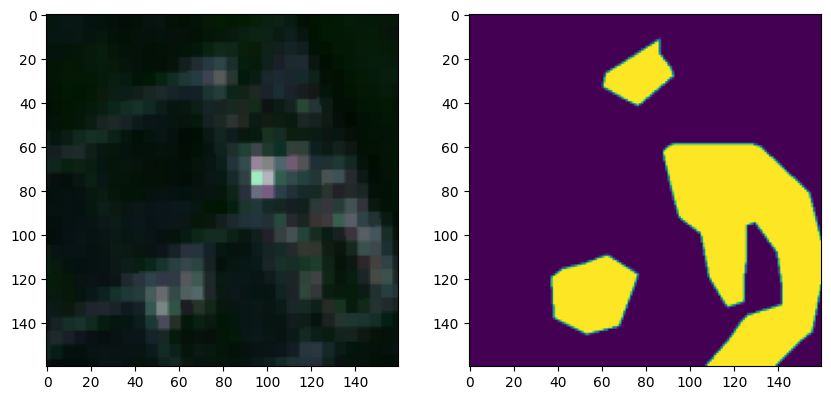

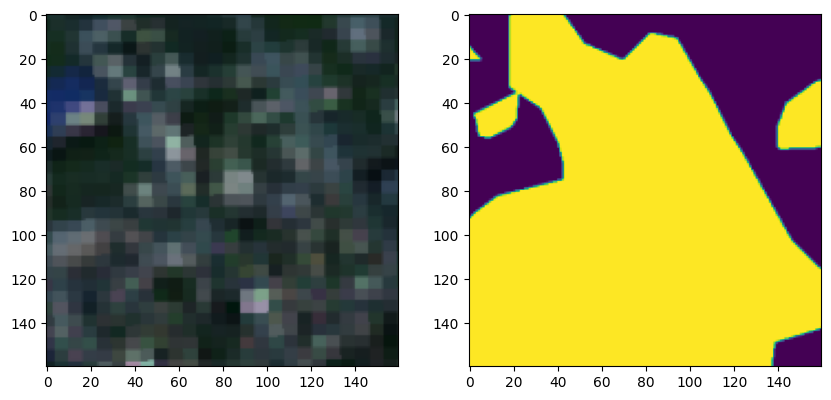

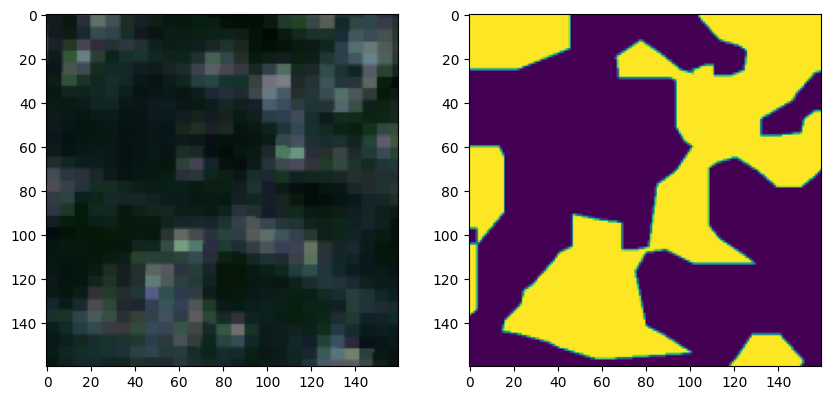

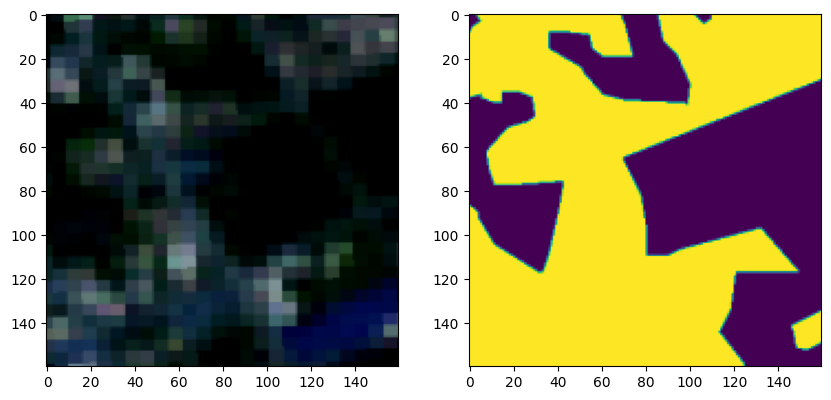

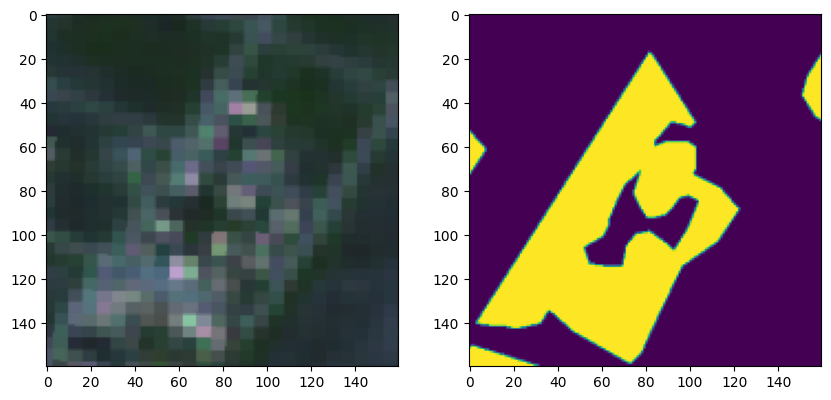

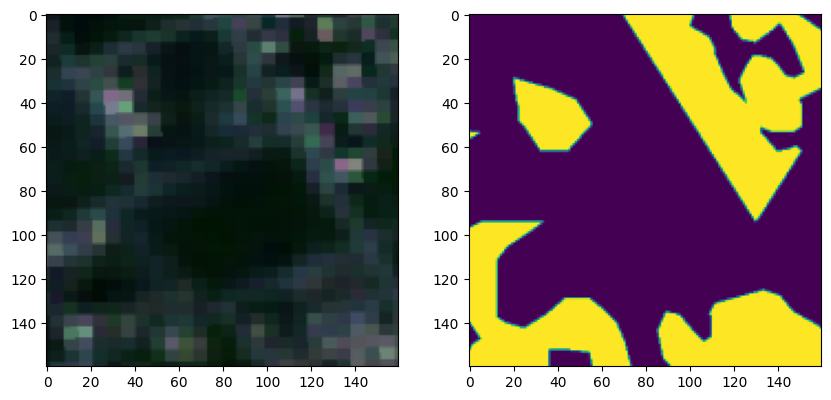

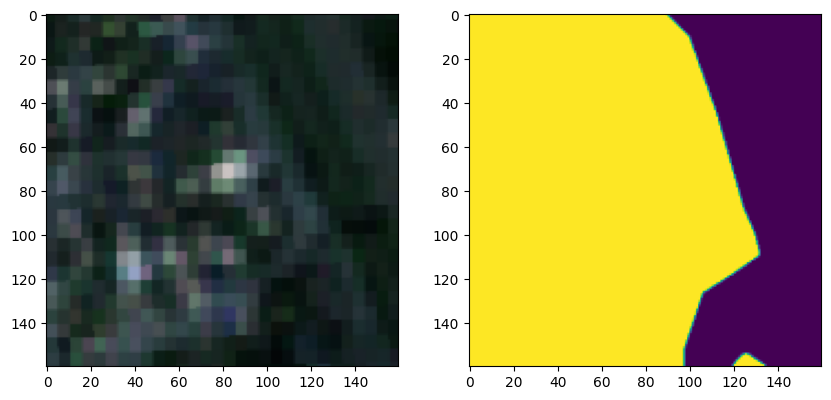

In [ ]:
plot_data_generator(num_samples=9, fig_size=(10, 10), train_config=config,img_ch = 3)

In [ ]:
res_config = train(config)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  1472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

'/content/drive/MyDrive/renabap/multibanda/UNet_renabap_4.h5'

For model evaluation, two mesaures were used:

+ Loss 
+ Intersection over Union (IoU)

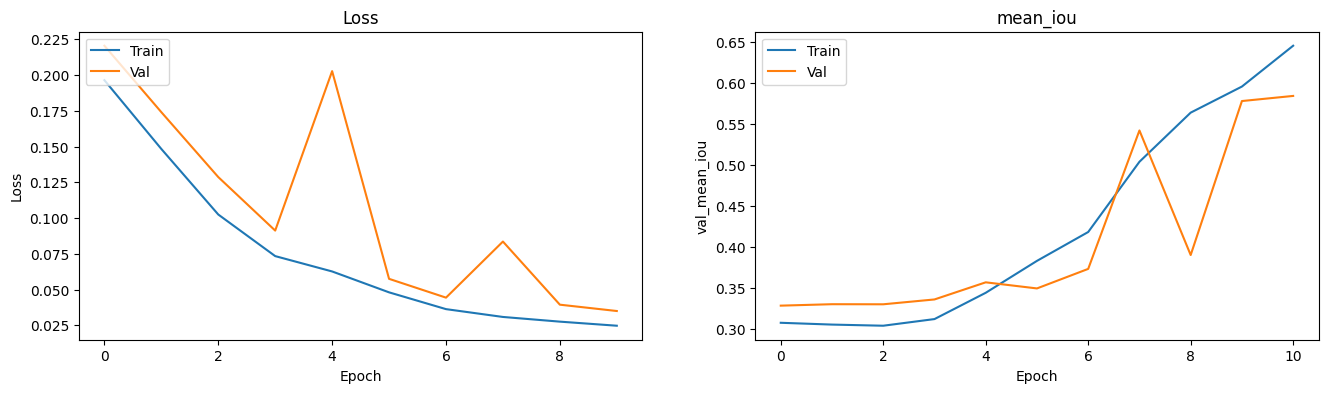

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'][1:])
plt.plot(res_config.history['val_loss'][1:])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history[list(res_config.history.keys())[1]])
plt.plot(res_config.history[list(res_config.history.keys())[3]])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()